## Deep Q Learning to play Atari from RAM

In [1]:
%matplotlib qt
import gym, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque
from tqdm.notebook import tqdm
import pickle

In [2]:
COLAB = False
RESUME = False
path_base = "models/"
if COLAB:
    path_base = "drive/My Drive/"
env = gym.make('Pong-ram-v0')
from datetime import datetime

In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
class Agent:
    def __init__(self, params):
        self.epsilon = 1
        self.decrease_till = params["annealation_count"]
        self.rate_per_step = 0.9/self.decrease_till
        self.discount = params["discount"]
        self.merge_frequency = params["merge_frequency"]
        self.save_frequency = params["save_frequency"]
        self.frame_size = params["frame_size"]
        self.num_actions = params["actions"]
        self.optimizer = params["optimizer"]
        self.experience_memory = params["memory"]
        self.memory = deque()
        self.experience = list()
        self.q_network = self.build_network()
        self.target_network = self.build_network()
        self.count = 0
        self.game = 0
        default = np.zeros((128, ))
        for _ in range(self.frame_size):
            self.memory.append(default)
        
    def merge_networks(self):
        self.target_network.set_weights(self.q_network.get_weights())
    def build_network(self):
        model = tf.keras.Sequential()
        initializer = tf.keras.initializers.GlorotUniform()
        model.add(tf.keras.layers.Dense(100, activation='relu', 
                        input_shape=(128*self.frame_size, ), kernel_initializer=initializer))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(self.num_actions, activation='linear', kernel_initializer=initializer))
        model.compile(loss='mse', optimizer= self.optimizer)
        return model
        
    def get_input(self, state):
        state = state/255
        self.memory.append(np.array(state))
        if len(self.memory) > self.frame_size:
            self.memory.popleft()
        input_layer = np.array([])
        for frame in self.memory:
            input_layer = np.concatenate([input_layer, frame])
        
        return input_layer
        
    def agent_start(self, start_state):
        input_layer = self.get_input(start_state)
        q_values = self.q_network.predict(np.array([input_layer]))
        
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = np.argmax(q_values[0])
        self.prev_state = input_layer
        self.prev_action = action 
        return action
    
    def agent_step(self, reward, state):
        self.count += 1
        if self.count > self.decrease_till:
            self.epsilon = 0.1
        else:
            self.epsilon = 1 - self.count*self.rate_per_step
        input_layer = self.get_input(state)
        q_values = self.q_network.predict(np.array([input_layer]))
        relay = (self.prev_state, self.prev_action,  reward, input_layer, 0)
        self.experience.append(relay)
        
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = np.argmax(q_values[0])
        self.prev_state = input_layer
        self.prev_action = action 
        return action, q_values[0][action]
        
    
    def agent_end(self, reward):
        relay = (self.prev_state, self.prev_action,  reward, self.prev_state, 1)
        self.experience.append(relay)
        self.train(10000)
        self.game += 1
        if len(self.experience) > self.experience_memory:
            self.experience.clear()
        
    def save_weights(self):
        self.q_network.save_weights(path_base + "q.h5")
        self.target_network.save_weights(path_base + "target.h5")
#         with open(path_base + "agent.obj", "wb") as f:
#             pickle.dump(self, f)
        
    def train(self, count):
        batch = random.sample(self.experience, min(count, len(self.experience)))
        step = 0
        input_tensor = [state for state, action, reward, future, terminated in batch]
        output_tensor = self.q_network.predict(np.array(input_tensor))
        future_input_tensor = [future for state, action, reward, future, terminated in batch]
        future_out = self.target_network.predict(np.array(future_input_tensor))
        for count, (state, action, reward, future, terminated) in enumerate(batch):
            target = output_tensor[count]
            updated = reward
            if not terminated:
                target_vals = future_out[count]
                updated += self.discount*np.amax(target_vals)
                
            target[action] = updated
            output_tensor[count] = target 
        
        input_tensor = np.array(input_tensor)
        output_tensor = np.array(output_tensor)
        self.q_network.fit(input_tensor, output_tensor, epochs=1, verbose=0)
            
        
        if self.game%self.merge_frequency == 0:
            self.merge_networks()
            
        if self.game%self.save_frequency == 0:
            self.save_weights()
        
    

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05)
params = {"annealation_count":100000, "merge_frequency": 7, "save_frequency": 10, "discount": 1, "frame_size": 3, "actions": 6, "optimizer": optimizer, "memory": 10000}
agent = Agent(params)

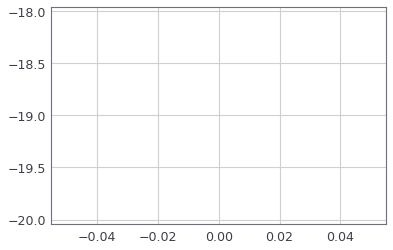

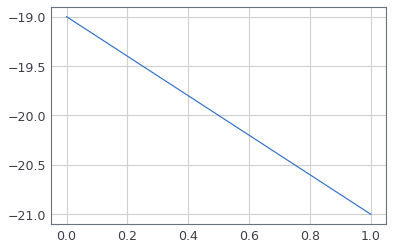

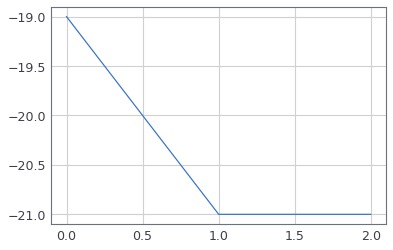

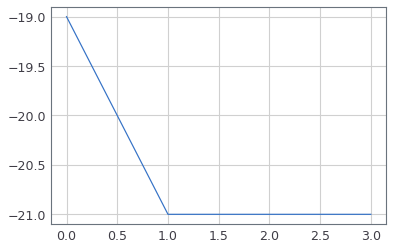

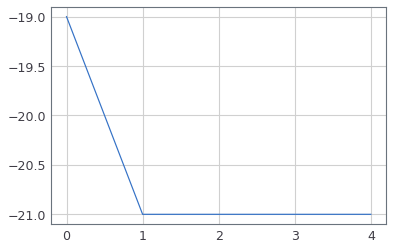

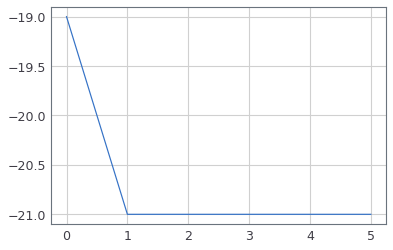

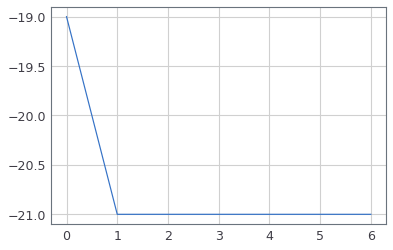

In [ ]:
ITERATIONS = 400
np.set_printoptions(precision=3)
render = False
gbar = tqdm(desc="Game: ", total=ITERATIONS)
pbar = tqdm(desc="Game Step: ")
y = []
x = []
for _ in range(ITERATIONS):
    action = agent.agent_start(env.reset())
    observation, reward, done, info = env.step([action])
    
    game_reward = 0
    while not done:
        action, value = agent.agent_step(reward, observation)
        observation, reward, done, info = env.step([action])
        game_reward += reward
        if render:
            env.render()
        pbar.set_description("Action Value {0} Game Step: ".format(value))
        pbar.update(1)
        
    y.append(game_reward)
    x.append(_)
    plt.plot(x, y)
    gbar.update(1)
    pbar.refresh()
    pbar.reset()
    agent.agent_end(reward)
    plt.show()
   

In [47]:
agent.q_network.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 80)                30800     
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 486       
Total params: 31,286
Trainable params: 31,286
Non-trainable params: 0
_________________________________________________________________


In [19]:
env.close()